In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lifelines as ll
import scipy.stats as stats
from lifelines import KaplanMeierFitter
from sksurv.tree import SurvivalTree

/Users/devanshishah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
liberia = pd.read_csv('/data/liberia.csv')
sl = pd.read_csv('/data/SierraLeone.csv')
guinea = pd.read_csv('/data/Guinea.csv')

In [ ]:
# define a dictionary with all the country datasets
dfs = {'guinea': guinea,
       'sierra leone': sl,
       'liberia': liberia}

# for each country
for name, df in dfs.items():
    # initialize an empty list to populate
    num_deaths_per_week = []
    # get the number of rows
    n = df.shape[0]
    # for each row in the dataframe
    for i in range(0, n):
        # if this is the first entry
        if i == 0:
            # the number of deaths for the week is equal to the total number of deaths
            v = df['Suspected/Confirmed/Probable Deaths'][i]
        else:
            # get the difference between the current total with last weeks total
            v = df['Suspected/Confirmed/Probable Deaths'][i] - df['Suspected/Confirmed/Probable Deaths'][i-1]
        # added current number of deaths to list
        num_deaths_per_week.append(v)
    # define a column with the number of deaths per week
    df['Deaths Per Week'] = num_deaths_per_week

In [ ]:
# since liberia has odd data entries, need to handle the data differently than the other countries
# initialize an empty list to populate
num_deaths_per_week = []
# get the number of rows
n = liberia.shape[0]
# for each row in the dataframe
for i in range(0, n):
    # if this is the first entry
    if i == 0:
        # the number of deaths for the week is equal to the total number of deaths
        v = liberia['Suspected/Confirmed/Probable Deaths'][i]
    else:
        # get the difference between the current total with last weeks total
        v = liberia['Suspected/Confirmed/Probable Deaths'][i] - df['Suspected/Confirmed/Probable Deaths'][i-1]
        # if the difference is negative, its from the newer data report
        if v < 0:
            # the total number corresponds to the current number of deaths
            v = liberia['Suspected/Confirmed/Probable Deaths'][i]
        # if the difference is very large
        if v >= 4000:
            # the difference is zero
            v = 0
    # add current number of deaths to list
    num_deaths_per_week.append(v)

# define a column with the number of deaths per week
liberia['Deaths Per Week'] = num_deaths_per_week

In [ ]:
# define a dictionary with all the country datasets
dfs = {'guinea': guinea,
       'sierra leone': sl,
       'liberia': liberia}
# for each country dataset
for name, df in dfs.items():
    # Convert date to datetime and calculate time in days since the first entry
    df['Date'] = pd.to_datetime(df['Date'])
    df['Time'] = (df['Date'] - df['Date'].min()).dt.days

    # Define Event based on a threshold: only set Event=1 for significant weekly death counts
    death_threshold = 10  # Adjust threshold based on analysis
    df['Event'] = (df['Deaths Per Week'] > death_threshold).astype(int)

    # Set right-censoring for weeks with deaths below the threshold or plateauing
    df['Censored'] = (df['Deaths Per Week'] <= death_threshold) | (df['Deaths Per Week'] == df['Deaths Per Week'].shift())


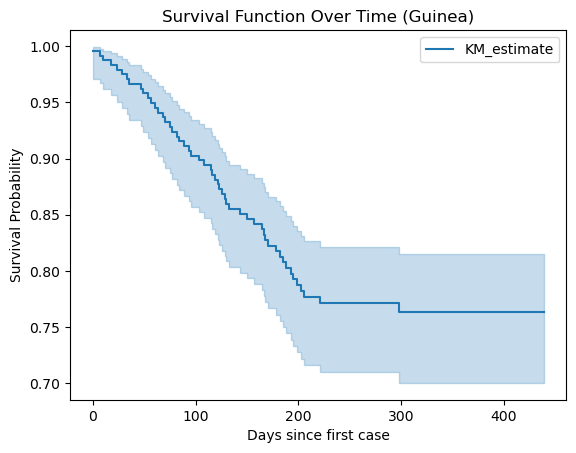

In [ ]:
# Kaplan-Meier Fitting with threshold-based censoring
g_kmf = KaplanMeierFitter()
g_kmf.fit(durations=guinea['Time'], event_observed=~guinea['Censored'])

# Plot the survival function
g_kmf.plot_survival_function()
plt.title('Survival Function Over Time (Guinea)')
plt.xlabel('Days since first case')
plt.ylabel('Survival Probability')
plt.show()


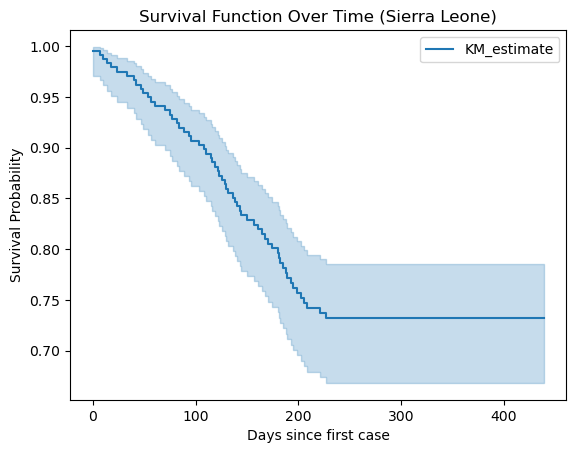

In [ ]:
# Kaplan-Meier Fitting with threshold-based censoring
sl_kmf = KaplanMeierFitter()
sl_kmf.fit(durations=sl['Time'], event_observed=~sl['Censored'])

# Plot the survival function
sl_kmf.plot_survival_function()
plt.title('Survival Function Over Time (Sierra Leone)')
plt.xlabel('Days since first case')
plt.ylabel('Survival Probability')
plt.show()

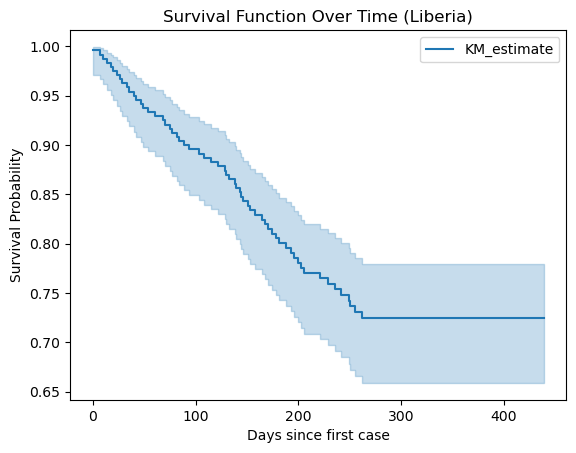

In [ ]:
# Kaplan-Meier Fitting with threshold-based censoring
l_kmf = KaplanMeierFitter()
l_kmf.fit(durations=liberia['Time'], event_observed=~liberia['Censored'])

# Plot the survival function
l_kmf.plot_survival_function()
plt.title('Survival Function Over Time (Liberia)')
plt.xlabel('Days since first case')
plt.ylabel('Survival Probability')
plt.show()

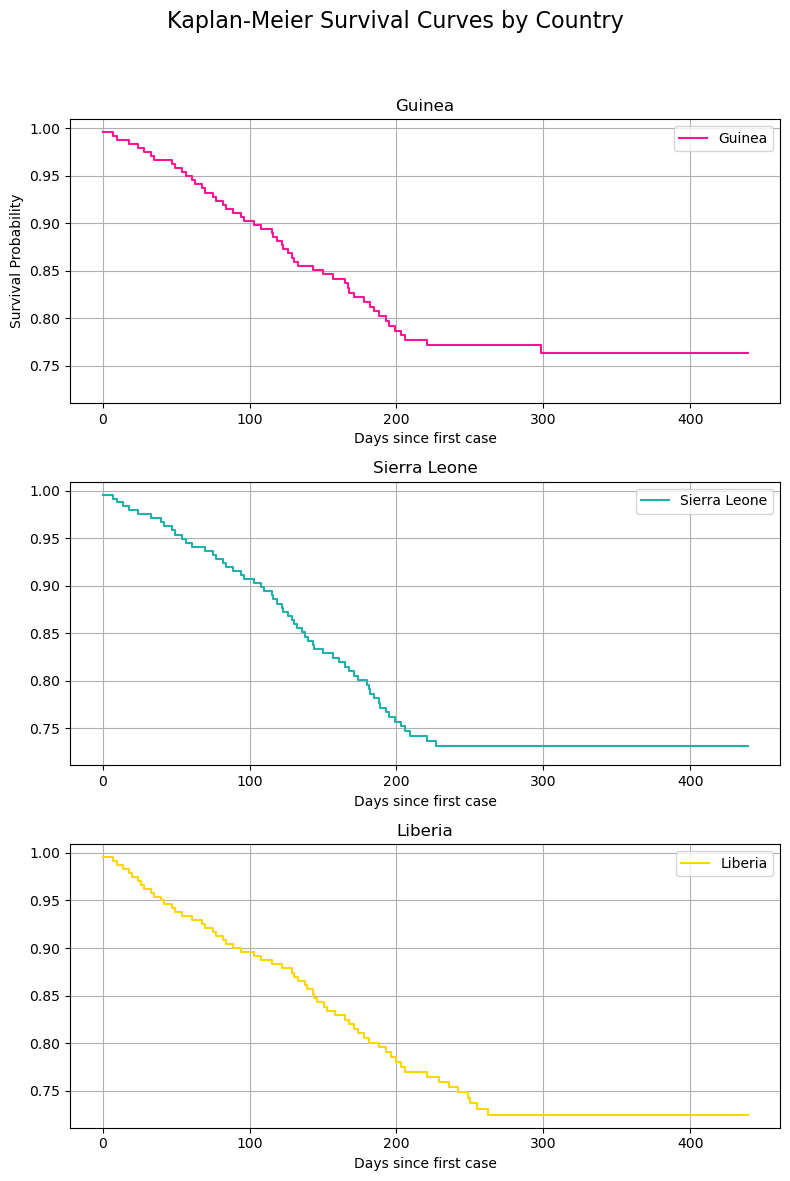

In [ ]:
# Create a figure with subplots (1 row, 3 columns in this example)
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=True)

# Plot each survival curve on a different subplot
g_kmf.plot(ax=axes[0], ci_show=False, color='deeppink', label='Guinea')
axes[0].set_title("Guinea")
axes[0].set_xlabel("Days since first case")
axes[0].set_ylabel("Survival Probability")
axes[0].grid(True)

sl_kmf.plot(ax=axes[1], ci_show=False, color='lightseagreen', label='Sierra Leone')
axes[1].set_title("Sierra Leone")
axes[1].set_xlabel("Days since first case")
axes[1].grid(True)

l_kmf.plot(ax=axes[2], ci_show=False, color='gold', label='Liberia')
axes[2].set_title("Liberia")
axes[2].set_xlabel("Days since first case")
axes[2].grid(True)

# Set the overall title and show the plot
fig.suptitle("Kaplan-Meier Survival Curves by Country", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


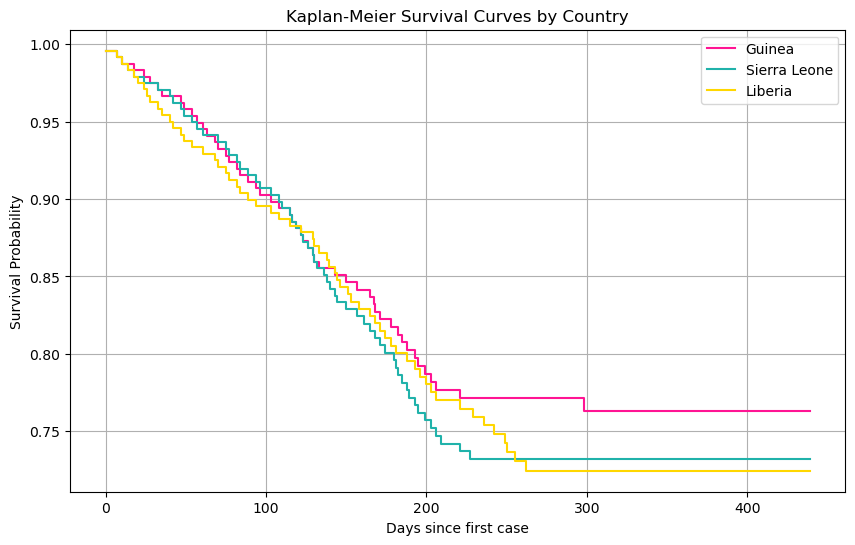

In [ ]:
# all countries
plt.figure(figsize=(10, 6))
g_kmf.plot(ci_show=False, color='deeppink', label='Guinea')
sl_kmf.plot(ci_show=False, color='lightseagreen', label='Sierra Leone')
l_kmf.plot(ci_show=False, color='gold', label='Liberia')
plt.title("Kaplan-Meier Survival Curves by Country")
plt.xlabel("Days since first case")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

In [ ]:
# sierra leone

In [ ]:
# get the mean values for each month to make the data more interpretable
sl['Date'] = pd.to_datetime(sl['Date'])
sl['Year'] = sl['Date'].dt.year
sl['Month'] = sl['Date'].dt.month
s_monthly_mean_cases = sl.groupby(['Year', 'Month'])['Suspected/Confirmed/Probable Cases'].mean().reset_index()
s_monthly_mean_deaths = sl.groupby(['Year', 'Month'])['Suspected/Confirmed/Probable Deaths'].mean().reset_index()
s_monthly_mean_cases['YearMonth'] = s_monthly_mean_cases['Year'].astype(str) + '-' + s_monthly_mean_cases['Month'].astype(str)
s_monthly_mean_cases['Deaths'] = s_monthly_mean_deaths['Suspected/Confirmed/Probable Deaths']


In [ ]:
# get the cummulative number of cases, deaths
s_monthly_mean_cases['cum_cases'] = s_monthly_mean_cases['Suspected/Confirmed/Probable Cases'].cumsum()
s_monthly_mean_cases['cum_deaths'] = s_monthly_mean_cases['Deaths'].cumsum()

Text(0.5, 1.0, 'Cases and Deaths for Sierra Leone')

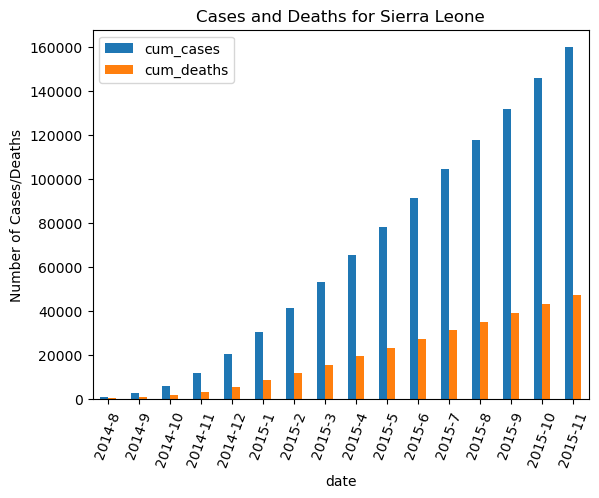

In [ ]:
# plot the cases and deaths for sierra leone
s_monthly_mean_cases.plot(x="YearMonth", y=["cum_cases", "cum_deaths"], kind="bar")
plt.xlabel('date')
plt.xticks(rotation=70)
plt.ylabel('Number of Cases/Deaths')
plt.title('Cases and Deaths for Sierra Leone')

In [ ]:
# guinea

In [ ]:
# get the mean values for each month to make the data more interpretable
guinea['Date'] = pd.to_datetime(guinea['Date'])
guinea['Year'] = guinea['Date'].dt.year
guinea['Month'] = guinea['Date'].dt.month
g_monthly_mean_cases = guinea.groupby(['Year', 'Month'])['Suspected/Confirmed/Probable Cases'].mean().reset_index()
g_monthly_mean_deaths = guinea.groupby(['Year', 'Month'])['Suspected/Confirmed/Probable Deaths'].mean().reset_index()
g_monthly_mean_cases['YearMonth'] = g_monthly_mean_cases['Year'].astype(str) + '-' + g_monthly_mean_cases['Month'].astype(str)
g_monthly_mean_cases['Deaths'] = g_monthly_mean_deaths['Suspected/Confirmed/Probable Deaths']

In [ ]:
# get cummulative number of cases, deaths
g_monthly_mean_cases['cum_cases'] = g_monthly_mean_cases['Suspected/Confirmed/Probable Cases'].cumsum()
g_monthly_mean_cases['cum_deaths'] = g_monthly_mean_cases['Deaths'].cumsum()


Text(0.5, 1.0, 'Cases and Deaths for Guinea')

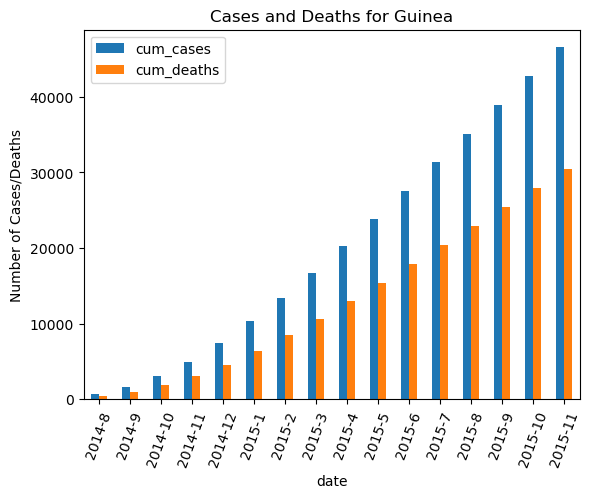

In [ ]:
# plot cases and deaths for Guinea
g_monthly_mean_cases.plot(x="YearMonth", y=["cum_cases", "cum_deaths"], kind="bar")
plt.xlabel('date')
plt.xticks(rotation=70)
plt.ylabel('Number of Cases/Deaths')
plt.title('Cases and Deaths for Guinea')

In [ ]:
# liberia

In [ ]:
# get the mean values for each month to make the data more interpretable
liberia['Date'] = pd.to_datetime(liberia['Date'])
liberia['Year'] = liberia['Date'].dt.year
liberia['Month'] = liberia['Date'].dt.month
l_monthly_mean_cases = liberia.groupby(['Year', 'Month'])['Suspected/Confirmed/Probable Cases'].mean().reset_index()
l_monthly_mean_deaths = liberia.groupby(['Year', 'Month'])['Suspected/Confirmed/Probable Deaths'].mean().reset_index()
l_monthly_mean_cases['YearMonth'] = l_monthly_mean_cases['Year'].astype(str) + '-' + l_monthly_mean_cases['Month'].astype(str)
l_monthly_mean_cases['Deaths'] = l_monthly_mean_deaths['Suspected/Confirmed/Probable Deaths']

In [ ]:
# get cummulative number of cases, deaths
l_monthly_mean_cases['cum_cases'] = l_monthly_mean_cases['Suspected/Confirmed/Probable Cases'].cumsum()
l_monthly_mean_cases['cum_deaths'] = l_monthly_mean_cases['Deaths'].cumsum()

Text(0.5, 1.0, 'Cases and Deaths for Liberia')

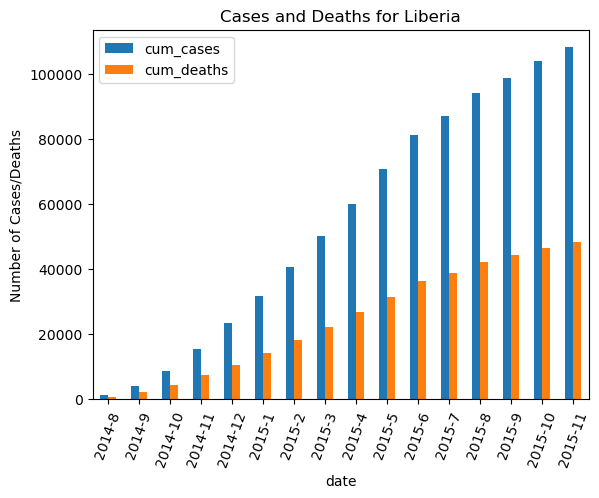

In [ ]:
# plot cases and deaths for liberia
l_monthly_mean_cases.plot(x="YearMonth", y=["cum_cases", "cum_deaths"], kind="bar")
plt.xlabel('date')
plt.xticks(rotation=70)
plt.ylabel('Number of Cases/Deaths')
plt.title('Cases and Deaths for Liberia')

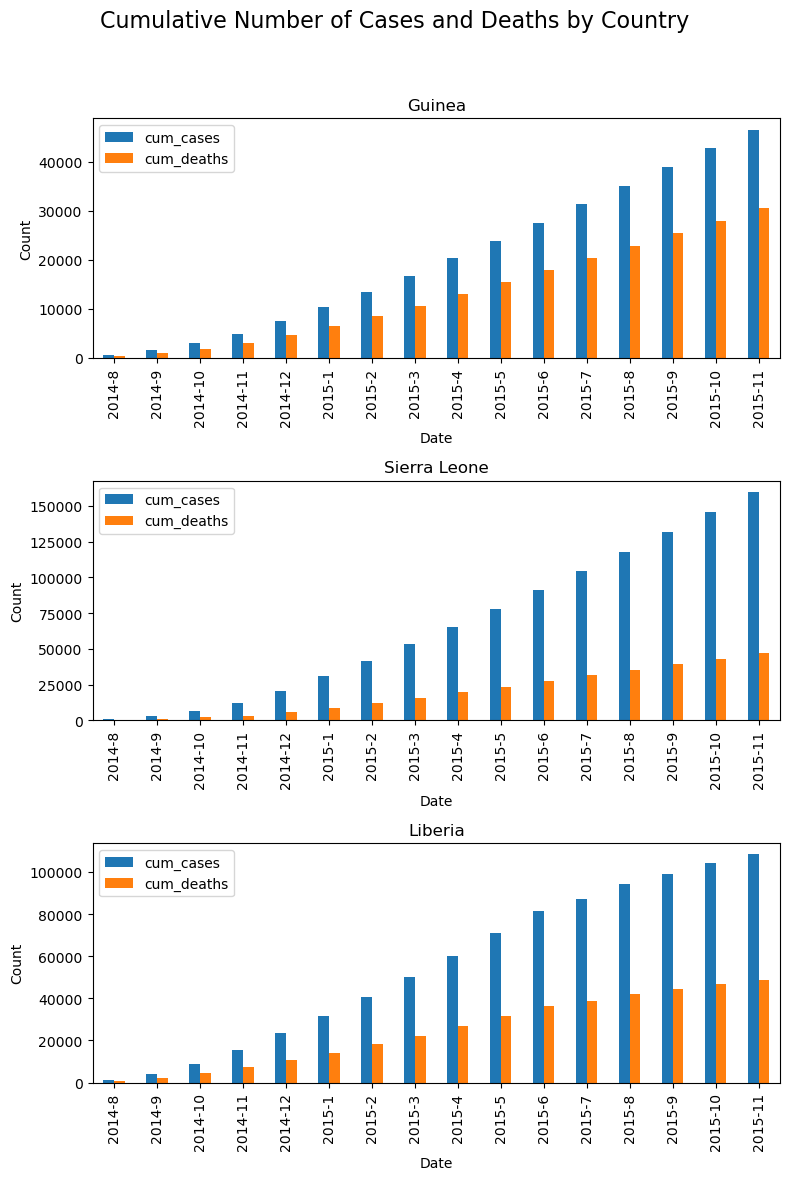

In [ ]:
# Create a figure with vertical subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=False)

# Plot each DataFrame on a separate subplot
g_monthly_mean_cases.plot(x="YearMonth", y=["cum_cases", "cum_deaths"], kind="bar", ax=axes[0], color=["#1f77b4", "#ff7f0e"])
axes[0].set_title("Guinea")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Count")

s_monthly_mean_cases.plot(x="YearMonth", y=["cum_cases", "cum_deaths"], kind="bar", ax=axes[1], color=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Sierra Leone")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Count")

l_monthly_mean_cases.plot(x="YearMonth", y=["cum_cases", "cum_deaths"], kind="bar", ax=axes[2], color=["#1f77b4", "#ff7f0e"])
axes[2].set_title("Liberia")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Count")

# Set the overall title and adjust layout
fig.suptitle("Cumulative Number of Cases and Deaths by Country", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the main title
plt.show()


#TODO: add vaccine, burial, and other intervention data to these plots to show how number of deaths decreased even if the number of cases increased indicating more and more people survived